# Introduction to PFL research with FLAIR
This tutorial demonstrates how to go beyond the basics of PFL, by implementing your own algorithm, postprocessors and aggregator for testing your own hypotheses.

We demonstrate this using image classification on the [FLAIR](https://github.com/apple/ml-flair) dataset. This is a multiclass classification image dataset with both coarse-grained and fine-grained classes. The dataset is inherently split into real users, which are the photographers of the images. This notebook will use the 17 coarse-grained classes for multi-class classification.

## 0.A (If on local Jupyter notebook) Install environment & `pfl`
To run this notebook locally with Jupyter and installing from source, follow these prerequisite steps:

1. Follow installation instructions at https://github.com/apple/pfl-research/blob/main/benchmarks/README.md#setup-environment
2. Activate the environment created by Poetry from (1) and add it to the notebook:
```
poetry shell
pip install jupyter
python -m ipykernel install --name "notebook-tutorial"
```
4. Start the notebook:
```
python -m jupyter notebook
```

In [ ]:
import sys
# Additional packages to run notebook
!{sys.executable} -m pip install h5py matplotlib nest_asyncio pandas torchvision

<div class="alert alert-block alert-warning">
If you installed the packages above, you need to restart the kernel of the notebook by clicking on "Kernel -> Restart"
</div>

## 0.B (If on Colab) Install environment & `pfl`
If you're running this notebook on colab, simply clone the pfl-research repo to access the data download and preprocess script, and then install prerequisite packages into existing environment:

In [ ]:
!git clone https://github.com/apple/pfl-research.git
import os
# Set the working directory to same as if running locally.
os.chdir('pfl-research/tutorials')

In [ ]:
import sys
# PyTorch should already be installed in colab
!{sys.executable} -m pip install pfl
# Additional packages to run notebook
!{sys.executable} -m pip install h5py matplotlib nest_asyncio pandas torchvision

## 1. Preparing data for simulations

The scripts `pfl-research/dataset/flair/download_dataset.py` and `pfl-research/dataset/flair/preprocess_dataset.py` can be used to download and preprocess the FLAIR dataset into a HDF5 file.
For simplicity of running this notebook, we will download a tiny, already preprocessed, version of the FLAIR dataset:

In [2]:
!wget -P ../benchmarks/data/ https://pfl-data.s3.us-east-2.amazonaws.com/flair/flair_federated_small.hdf5

--2024-07-19 16:32:48--  https://pfl-data.s3.us-east-2.amazonaws.com/flair/flair_federated_small.hdf5
Resolving pfl-data.s3.us-east-2.amazonaws.com (pfl-data.s3.us-east-2.amazonaws.com)... 52.219.93.194, 52.219.102.194, 3.5.132.244, ...
Connecting to pfl-data.s3.us-east-2.amazonaws.com (pfl-data.s3.us-east-2.amazonaws.com)|52.219.93.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 552428318 (527M) [binary/octet-stream]
Saving to: ‘../benchmarks/data/flair_federated_small.hdf5’

flair_federated_sma 100%[===================>] 526.84M  1.83MB/s    in 4m 35s  

2024-07-19 16:37:24 (1.91 MB/s) - ‘../benchmarks/data/flair_federated_small.hdf5’ saved [552428318/552428318]



In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd
import sys
import torch

# Both Jupyter and `pfl` use async. `nest_asyncio` allows `pfl` to run inside the notebook 
import nest_asyncio
nest_asyncio.apply()

# append the root directory to your paths to be able to reach the examples.  
sys.path.append('../benchmarks')
torch.random.manual_seed(1)
np.random.seed(1)

# Always import the `pfl` model first before initializing any `pfl` components to let `pfl` know which Deep Learning framework you will use.
from pfl.model.pytorch import PyTorchModel

Use helper functions from `pfl-research/benchmarks/dataset/flair/common.py` to load information about the data and labels from HDF5 file.

In [2]:
from dataset.flair.common import (get_multi_hot_targets, get_label_mapping, get_user_num_images)

#hdf5_path = '../benchmarks/data/flair_federated.hdf5'
hdf5_path = '../benchmarks/data/flair_federated_small.hdf5'
# A dictionary mapping class name to an output index.
classes = get_label_mapping(hdf5_path, use_fine_grained_labels=False)
num_classes = len(classes)

# A dictionary mapping each user id to number of images.
user_num_images = get_user_num_images(hdf5_path, 'train')
user_ids = sorted(list(user_num_images.keys()))

display('Coarse grained classes in FLAIR:')
display((classes))
display('User dataset sizes statistics')
display(pd.Series(user_num_images.values()).describe().apply("{0:.1f}".format))

Creating user_num_images for train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 5596.52it/s]


'Coarse grained classes in FLAIR:'

{'animal': 0,
 'art': 1,
 'celebration': 2,
 'equipment': 3,
 'fire': 4,
 'food': 5,
 'games': 6,
 'interior_room': 7,
 'light': 8,
 'liquid': 9,
 'material': 10,
 'music': 11,
 'outdoor': 12,
 'plant': 13,
 'recreation': 14,
 'religion': 15,
 'structure': 16}

'User dataset sizes statistics'

count    312.0
mean       7.0
std        5.5
min        1.0
25%        2.0
50%        6.0
75%       11.0
max       20.0
dtype: object

![Label distribution](./assets/label-dist-small.png)

As displayed above, the label of each image is a multi-hot vector of 17 classes. The user dataset sizes can be seen to be right-skewed, with 50% of users having <= 11 images, but the mean number of images per user 67.6 images.

Since the data is inherently split into real users, we need to use [FederatedDataset](https://apple.github.io/pfl-research/reference/data.html#pfl.data.federated_dataset.FederatedDataset), which requires a function for sampling user IDs.

Firstly, we define a function which samples user IDs uniformly at random (with replacement for simplicity). In real federated learning, users aren't typically available on a uniformly random basis, but researchers commonly make this simplification.

In [3]:
user_sampler = lambda: user_ids[np.random.randint(0, len(user_ids))]
print('sampled 10 users:', [user_sampler() for _ in range(10)])

sampled 10 users: ['130597631@N02', '61860846@N05', '156117665@N04', '73915715@N00', '52731864@N04', '34667242@N00', '37578955@N04', '33470929@N05', '15567950@N00', '62747771@N00']


The federated dataset is initialized using the above sampling function and a function that returns the user's dataset given its ID as input, `make_dataset_fn(user_id)`.

In [4]:
from pfl.data.dataset import Dataset
from pfl.data.federated_dataset import FederatedDataset
# `pfl.internal.ops` contains useful helper functions for manipulating tensors.
from pfl.internal.ops import pytorch_ops as ops

def make_dataset_fn(user_id):
    with h5py.File(hdf5_path, 'r') as h5:
        inputs = (np.array(h5[f'/train/{user_id}/images']) - 128) / 255.
        # Get multi-hot labels for user.
        # The zip of `row_indices` and `col_indices` is the sparse matrix of labels for a user.
        row_indices = np.array(h5[f'/train/{user_id}/labels_row'])        
        col_indices = np.array(h5[f'/train/{user_id}/labels_col'])
        # Convert to a dense matrix of labels.
        targets = np.zeros((len(inputs), 17), dtype=np.float32)
        targets[row_indices, col_indices] = 1

    return Dataset((
        ops.to_tensor(inputs), 
        ops.to_tensor(targets)), user_id=user_id)

train_federated_dataset = FederatedDataset(make_dataset_fn, user_sampler)

When iterating through the federated dataset, a user dataset is sampled every iteration.

User: 39427725@N00
unique user seed: 1819782793
dataset length: 17
first 10 images:


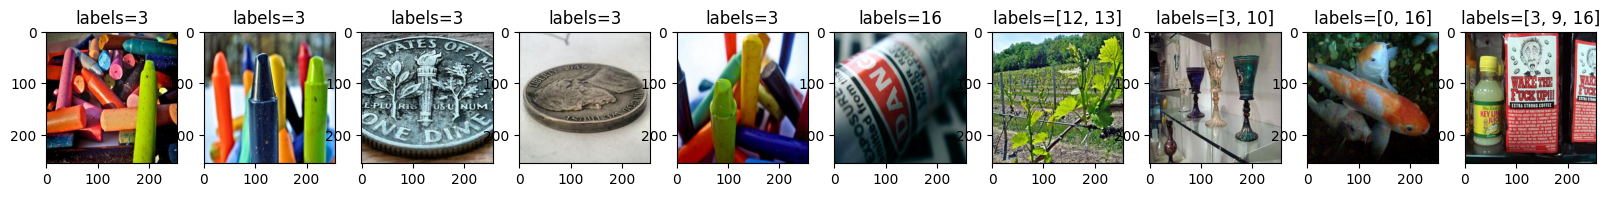

In [10]:
import itertools

user, seed = next(train_federated_dataset)
print('User: {}\nunique user seed: {}\ndataset length: {}\nfirst 10 images:'.format(user.user_id, seed, len(user)))
fig, axes = plt.subplots(1,min(len(user),10),figsize=(20,12))
for ax, image, label in itertools.islice(zip(axes, *user.raw_data),10):
    ax.set_title('labels={}'.format(torch.nonzero(label).squeeze().tolist()))
    ax.imshow((image.cpu().numpy()*255+128).astype(np.uint8))

We also create a central dataset for central evaluation using a helper function available in `pfl-research`:

In [11]:
from dataset.flair.common import make_central_datasets
inputs_all, targets_all = [], []
with h5py.File(hdf5_path, 'r') as h5:
    for user_id in h5[f'/val'].keys():
        inputs = (np.array(h5[f'/val/{user_id}/images']) - 128) / 255.
        # Get multi-hot labels for user.
        row_indices = np.array(h5[f'/val/{user_id}/labels_row'])
        col_indices = np.array(h5[f'/val/{user_id}/labels_col'])
        targets = np.zeros((len(inputs), 17), dtype=np.float32)
        targets[row_indices, col_indices] = 1
        inputs_all.append(inputs)
        targets_all.append(targets)

inputs_all = np.vstack(inputs_all)
targets_all = np.vstack(targets_all)
data_tensors = [inputs_all, targets_all]
central_data = Dataset(raw_data=data_tensors)
print('data shape:', [t.shape for t in central_data.raw_data])
print('fraction of positive labels:', central_data.raw_data[1].sum())

data shape: [(365, 256, 256, 3), (365, 17)]
fraction of positive labels: 1014.0


As displayed above, the images are of dimensions `256x256` with `3` color channels.

## 2. Defining the model

Defining a model in `pfl` is exactly the same as you would normally define a model for training. One of `pfl`’s strengths is that it is agnostic to any Deep Learning framework, which enables `pfl` to support multiple Deep Learning frameworks. 

Frameworks supported by `pfl` server-side are PyTorch and TensorFlow.
`pfl` also support ML models like GBDTs which use numpy.

We will define a PyTorch model in the exact same way as we would for regular centralized training.

In [12]:
from typing import Dict, Optional
from pfl.metrics import Weighted
import torch
from torchvision.models import resnet18, ResNet18_Weights

# Initialize model with pretrained weights.
weights = ResNet18_Weights.DEFAULT
pytorch_model = resnet18(weights=weights)

# Modify final classification layer.
num_ftrs = pytorch_model.fc.in_features
pytorch_model.fc = torch.nn.Linear(num_ftrs, 17)

# Freeze all layers.
for param in pytorch_model.parameters():
    param.requires_grad = False

# Then unfreeze the last dense layer and final resnet block.
for param in list(pytorch_model.fc.parameters()) + list(pytorch_model.layer4.parameters()):
    param.requires_grad = True

loss_fn = torch.nn.BCEWithLogitsLoss()

def loss(inputs: torch.Tensor, targets: torch.Tensor, eval: bool = False) -> torch.Tensor:
    pytorch_model.eval() if eval else pytorch_model.train()
    return loss_fn(pytorch_model(inputs.permute((0,3,1,2))), targets)


@torch.no_grad()
def metrics(inputs: torch.Tensor,
             targets: torch.Tensor,
             eval: bool = True) -> Dict[str, Weighted]:
    pytorch_model.eval() if eval else pytorch_model.train()
    logits = pytorch_model(inputs.permute((0,3,1,2)))
    num_samples = len(inputs)
    num_predictions = targets.numel()
    correct = torch.sum(torch.eq((logits > 0.0).float(), targets))

    loss = loss_fn(logits, targets).item()
    return {
        "loss": Weighted(loss, num_samples),
        "accuracy": Weighted(correct, num_predictions)
    }

pytorch_model.loss = loss
pytorch_model.metrics = metrics
pytorch_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

A `pfl` `Model` acts as an adapter between the model defined using a Deep Learning framework and pfl. In this example, we use PyTorch to define our model, and so use `PyTorchModel` as the adapter.

The central optimizer is an input parameter to the `pfl` `PyTorchModel` object. This optimizer is used when applying the aggregated model update to the central model.

In [13]:
params = [p for p in pytorch_model.parameters() if p.requires_grad]

model = PyTorchModel(pytorch_model, 
                     local_optimizer_create=torch.optim.SGD,
                     central_optimizer=torch.optim.SGD(params, 1.0))

# Save initial model
model.save('tutorial_model')

## 3. Training a model using Private Federated Learning

`Backend` is a component in `pfl` used to collect and aggregate statistics from user devices. [SimulatedBackend](https://apple.github.io/pfl-research/reference/aggregate.html#pfl.aggregate.SimulatedBackend) enables simulations to run for aggregating statistics from user devices.

In [14]:
from pfl.aggregate.simulate import SimulatedBackend

cohort_size = 10
central_num_iterations = 5

# Instantiate simulated federated averaging
simulated_backend = SimulatedBackend(
    training_data=train_federated_dataset,
    val_data=None)

The main component of a `pfl` modeling setup is the algorithm. In this tutorial, we will be using the [Federated Averaging](https://arxiv.org/pdf/1602.05629.pdf) algorithm. `pfl` implements Federated Averaging using the class [FederatedAveraging](https://apple.github.io/pfl-research/reference/algorithm.html#pfl.algorithm.federated_averaging.FederatedAveraging).

Everything is tied together in the `run` method of an algorithm. This method requires the model, backend, optional callbacks, as well as hyperparameters, which depend on the model and algorithm, and are respectively defined using `NNTrainHyperParams` and `NNAlgorithmParams` objects.

Hyperparameters regarding local training commonly have a prefix `local_` and hyperparameters regarding central updates commonly have a prefix `central_`. Important hyperparameters for federated learning include `local_learning_rate` and `local_num_epochs` which respectively specify the learning rate and the number of training epochs to be used for local training on devices during federated averaging. These hyperparameters differ to `central_learning_rate` and `central_num_iterations` which apply to training the central model using aggregated updates from devices.

In [15]:
from pfl.algorithm import FederatedAveraging, NNAlgorithmParams
from pfl.callback.central_evaluation import CentralEvaluationCallback
from pfl.hyperparam import NNTrainHyperParams, NNEvalHyperParams

model_train_params = NNTrainHyperParams(
    local_learning_rate=0.01,
    local_num_epochs=2,
    local_batch_size=16)

model_eval_params = NNEvalHyperParams(local_batch_size=20)

algorithm_params = NNAlgorithmParams(
    central_num_iterations=central_num_iterations,
    evaluation_frequency=4,
    train_cohort_size=cohort_size,
    val_cohort_size=0)

callbacks = [
    CentralEvaluationCallback(
        central_data,
        model_eval_params=model_eval_params,
        frequency=4),
]

model = FederatedAveraging().run(
    algorithm_params=algorithm_params,
    backend=simulated_backend,
    model=model,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=callbacks)


Metrics at iteration 0 ():
    Central val | loss                                : 0.03712028673250381
    Central val | accuracy                            : 0.5141015310233682
    Central val | number of data points               : 365
    Train population | number of devices              : 10
    Train population | number of data points          : 7.9
    Train population | loss before local training     : 0.09107293433780912
    Train population | accuracy before local training : 0.4914370811615786
    Train population | loss after local training      : 0.07954692840576172
    Train population | accuracy after local training  : 0.637379002233805
    Train population | total weight                   : 1.0
    Number of parameters                              : 8402449
    Learning rate                                     : 1.0
Metrics at iteration 1 ():
    Train population | number of devices              : 10
    Train population | number of data points          : 6.4
    Train po

## 4. Defining a custom algorithm
`pfl` has excellent interfaces for implementing your own research ideas.
Extend the algorithm class when you want to test ideas related to the local training procedure or how the aggregated statistics are handled and applied to the central model. There are 3 base classes you can subclass to make your algorithm:
* [FederatedAlgorithm](https://apple.github.io/pfl-research/reference/algorithm.html#pfl.algorithm.base.FederatedAlgorithm)
* [FederatedNNAlgorithm](https://apple.github.io/pfl-research/reference/algorithm.html#pfl.algorithm.base.FederatedNNAlgorithm)
* [PersonalizedNNAlgorithmParams](https://apple.github.io/pfl-research/reference/algorithm.html#pfl.algorithm.base.PersonalizedNNAlgorithmParams)

See respective reference for when each interface is appropriate to use. In the case of training a nerual network model with Federated Learning, it is easiest to use [FederatedNNAlgorithm](https://apple.github.io/pfl-research/reference/algorithm.html#pfl.algorithm.base.FederatedNNAlgorithm). Below is an example of a custom algorithm class that reimplements Federated Averaging using PyTorch operations:

In [16]:
from pfl.algorithm.base import FederatedNNAlgorithm
from pfl.metrics import Metrics

central_opt = torch.optim.Adam([p for p in pytorch_model.parameters() if p.requires_grad], lr=1.0)
        
class MyAlgorithm(FederatedNNAlgorithm):
        
    def process_aggregated_statistics(self, central_context, aggregate_metrics, model, stats):
        stats.average()
        
        # Below is equivalent to 
        # return model.apply_model_update(statistics)
        central_opt.zero_grad()
        for name, var in model.pytorch_model.named_parameters():
            if not var.requires_grad:
                # Frozen variable
                continue
            if var.grad is None:
                var.grad = torch.zeros_like(var)
            var.grad.data.copy_(-1*stats[name])
        central_opt.step()
        
        return model, Metrics([('I updated it', 1.0)])

    
    def train_one_user(self, initial_state, model, user_dataset, central_context):
        opt = torch.optim.SGD(model.pytorch_model.parameters(), lr=0.1)
        opt.zero_grad()
        for x, y in user_dataset.iter(5):
            model.pytorch_model.loss(x, y).backward()
            opt.step()
        return model.get_model_difference(initial_state), Metrics([('I trained it', 1.0)])

Now when running the custom algorithm, we will see the two new metrics `I updated it` and `I trained it` emitted.

In [17]:
# Reset from initial weights
model.load('tutorial_model')

model = MyAlgorithm().run(
    algorithm_params=algorithm_params,
    backend=simulated_backend,
    model=model,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=callbacks)

Metrics at iteration 0 ():
    Central val | accuracy                            : 0.5141015310233682
    Central val | loss                                : 0.03712028607930223
    Central val | number of data points               : 365.0
    Train population | number of devices              : 10
    Train population | number of data points          : 6.9
    Train population | loss before local training     : 0.10912887860035551
    Train population | accuracy before local training : 0.48081841432225064
    I trained it                                      : 10.0
    Train population | loss after local training      : 0.03830664097398952
    Train population | accuracy after local training  : 0.8994032395566922
    Train population | total weight                   : 1.0
    Number of parameters                              : 8402449
    I updated it                                      : 1.0
Metrics at iteration 1 ():
    Train population | number of devices              : 10
    Tra

## 5. Defining a dynamic hyperparameter
The Federated Learning training paradigm often adds many more hyperparameters to tune. Therefore, it can be a good idea to make hyperparameters dynamic and more intelligent. In `pfl`'s library of algorithms and models, many of the hyperparameters are allowed to be dynamic in the form of a [HyperParam](https://apple.github.io/pfl-research/reference/hyperparam.html#pfl.hyperparam.base.HyperParam). It is a base class with a single method `value()`, where concrete implementations should return the value of the hyperparameter at that point in time.

To dynamically change the value during training, the concrete subclass implementation can also extend one of the two different hooks that `pfl` calls into during training:
* [Callback](https://apple.github.io/pfl-research/reference/callback.html#pfl.callback.base.TrainingProcessCallback) - has one hook for each of: before training begins; at the end of each central iteration; and after all central iterations of training have ended.
* [Postprocessor](https://apple.github.io/pfl-research/reference/postprocessor.html#pfl.postprocessor.Postprocessor) - has one hook at the postprocessing stage of an individual user and one hook at the postprocessing stage of the aggregated model update, before it is sent to the algorithm.

Here is an example of a local learning rate warmup implementation. We extend `TrainingProcessCallback`, but `Postprocessor.postprocess_server` could have worked equally well.

In [18]:
from pfl.hyperparam import HyperParam
from pfl.callback.base import TrainingProcessCallback

class LocalLRWarmup(HyperParam, TrainingProcessCallback):
    def __init__(self, initial_value: float, max_value: float):
        self._value = initial_value
        self._max_value = max_value
      
    def value(self):
        return self._value

    def after_central_iteration(self, aggregate_metrics, model, central_iteration):
        self._value = min(self._value*5, self._max_value)
        return False, Metrics([('dynamic local lr', self._value)])


We can now add an instance of `LocalLRWarmup` as the actual argument to `local_learning_rate`. Also make sure to add the same instance as one of the callbacks in `run` such that updating the internal value is actually triggered. 

In [19]:
# Reset from initial weights
model.load('tutorial_model')

local_lr = LocalLRWarmup(0.0001, 0.1)

simulated_backend = SimulatedBackend(
    training_data=train_federated_dataset,
    val_data=None)

model_train_params = NNTrainHyperParams(
    local_learning_rate=local_lr,
    local_num_epochs=2,
    local_batch_size=5)

model = MyAlgorithm().run(
    algorithm_params=algorithm_params,
    backend=simulated_backend,
    model=model,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=callbacks + [local_lr])

Metrics at iteration 0 ():
    Central val | accuracy                            : 0.5141015310233682
    Central val | loss                                : 0.03712028607930223
    Central val | number of data points               : 365.0
    Train population | number of devices              : 10
    Train population | number of data points          : 4.7
    Train population | loss before local training     : 0.15070241689682007
    Train population | accuracy before local training : 0.49436795994993743
    I trained it                                      : 10.0
    Train population | loss after local training      : 0.06427115836042038
    Train population | accuracy after local training  : 0.8973717146433041
    Train population | total weight                   : 1.0
    Number of parameters                              : 8402449
    I updated it                                      : 1.0
    Dynamic local lr                                  : 0.0005
Metrics at iteration 1 ():
   

## 5. Defining a custom postprocessor
Assuming aggregation is a black box that securely aggregates the user payloads without being able to inspect each payload individually on the server, there are ideas that can improve the overall practical Federated Learning experience by manipulating the payload before communication and after aggregation. This concept is called [Postprocessor](https://apple.github.io/pfl-research/reference/postprocessor.html#pfl.postprocessor.Postprocessor) in `pfl` and is orthogonal to a `Model`, `Algorithm` and `Aggregator`. Some categories of research that may be expressed as a `Postprocessor` are (but not limited to):
* [Privacy mechanisms](https://apple.github.io/pfl-research/reference/privacy.html)
* Quantization
* Sparsification
* Weighting

Below we implement top-K sparsification as a `Postprocessor`, which will zero out `1-top_k_percent` percent of the model update elements with the lowest absolute values, making the model update sparse.

In [20]:
from typing import Tuple
from pfl.context import CentralContext, UserContext
from pfl.postprocessor import Postprocessor
from pfl.stats import TrainingStatistics

class SparsifyTopK(Postprocessor):
    def __init__(self, top_k_percent: int = 0.1):
        self._top_k_percent = top_k_percent
        
    def postprocess_one_user(self, stats: TrainingStatistics, user_context: UserContext) -> Tuple[TrainingStatistics, Metrics]:
        # Flatten to vector
        metadata, weights = stats.get_weights()
        vector, shapes, types = ops.flatten(weights)

        # Mask topK
        num_top_elements = int(self._top_k_percent * len(vector))
        _, indices = torch.topk(vector.abs(), num_top_elements)
        mask = torch.zeros(len(vector), dtype=torch.bool, device=ops.get_default_device())
        mask[indices] = 1
        sparse_vector = vector * mask
        actual_sparsity = (sparse_vector == 0).sum() / len(sparse_vector)

        # Reshape sparse vector to weights of correct shapes
        sparse_weights = ops.reshape(sparse_vector, shapes, types)
        sparse_stats = stats.from_weights(metadata, sparse_weights)
        
        return sparse_stats, Metrics([('sparsity', Weighted.from_unweighted(actual_sparsity))])

    def postprocess_server(self, *, stats: TrainingStatistics, 
                           central_context: CentralContext,
                           aggregate_metrics: Metrics) -> Tuple[TrainingStatistics, Metrics]:
        return stats, Metrics()


Now we can input `SparsifyTopK` as one of the postprocessors and re-run the algorithm. The new `sparsity` metric measures the actual sparsity in the user payload, which should match `1-top_k_percent`.
<div class="alert alert-block alert-warning">
This kind of sparsification algorithm is commonly exercised in Federated Learning research litterature, but it is actually not compatible with Differential Privacy! Do you notice why?
</div>

In [21]:
# Reset from initial weights
model.load('tutorial_model')

simulated_backend = SimulatedBackend(
    training_data=train_federated_dataset,
    val_data=None,
    postprocessors=[
        SparsifyTopK(0.5),
    ])

model_train_params = NNTrainHyperParams(
    local_learning_rate=0.5,
    local_num_epochs=2,
    local_batch_size=5)

model = MyAlgorithm().run(
    algorithm_params=algorithm_params,
    backend=simulated_backend,
    model=model,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=callbacks)

Metrics at iteration 0 ():
    Central val | accuracy                            : 0.5141015310233682
    Central val | loss                                : 0.03712028607930223
    Central val | number of data points               : 365.0
    Train population | number of devices              : 10
    Train population | number of data points          : 6.1
    Train population | loss before local training     : 0.11399973904500242
    Train population | accuracy before local training : 0.5294117647058824
    I trained it                                      : 10.0
    Train population | loss after local training      : 0.04779841054658421
    Train population | accuracy after local training  : 0.9161041465766635
    Sparsity                                          : 0.5000000596046448
    Train population | total weight                   : 1.0
    Number of parameters                              : 8402449
    I updated it                                      : 1.0
Metrics at iteratio

## 6. Defining a custom aggregator
It is also possible to define your own aggregation scheme in `pfl`. [Aggregator](https://apple.github.io/pfl-research/reference/aggregate.html#pfl.aggregate.base.Aggregator) is an interface which lets you define how a model update from the user should be combined with the current accumulated statistics. If you want the aggregator to be compatible with distributed simulations you also need to implement `Aggregator.worker_reduce`.

In the example below, we define a custom aggregator that combines two model updates by, for each element, selecting the value of the highest magnitude.

In [22]:
from pfl.aggregate.base import Aggregator
from pfl.stats import TrainingStatistics

class MaxMagAggregator(Aggregator):
    def accumulate(self, accumulated: Optional[TrainingStatistics], user_stats: TrainingStatistics) -> TrainingStatistics:
        if accumulated is None:
            # For the first statistics, simply return it.
            return user_stats

        for name in accumulated.keys():
            accumulated_weight = accumulated[name]
            user_weight = user_stats[name]
            accumulated[name] = torch.where(
                torch.abs(accumulated_weight) > torch.abs(user_weight), 
                accumulated_weight, 
                user_weight)
        # Statistics might have a custom weight from the algorithm or other postprocessor.
        # Reset it to 1 because we are not doing any weighted aggregation here.
        accumulated.weight = 1
        return accumulated

    def worker_reduce(self, 
        aggregated_worker_stats: TrainingStatistics,
        central_context: CentralContext, 
        aggregated_worker_metrics: Metrics) -> Tuple[TrainingStatistics, Metrics]:
        """
        User statistics and metrics are first summed on each worker process,
        then they are reduced across workers using this method.
        This method can be ignored in concrete aggregator classes if it is
        not compatible with multi-process training.

        In the case of this example, we don't need it.
        
        TODO: actually show how it would look like to support distributed
        simulations for this class.
        """
        raise NotImplementedError


`SimulatedBackend` has an optional argument `aggregator` where we will input `MaxMagAggregator` to override the default aggregation scheme (which is summing in `accumulate` and all-reduce sum in `worker_reduce`).

In [23]:
# Reset from initial weights
model.load('tutorial_model')

simulated_backend = SimulatedBackend(
    training_data=train_federated_dataset,
    val_data=None,
    aggregator=MaxMagAggregator())

model = MyAlgorithm().run(
    algorithm_params=algorithm_params,
    backend=simulated_backend,
    model=model,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=callbacks)

Metrics at iteration 0 ():
    Central val | accuracy                            : 0.5141015310233682
    Central val | loss                                : 0.03712028607930223
    Central val | number of data points               : 365.0
    Train population | number of devices              : 10
    Train population | number of data points          : 8.6
    Train population | loss before local training     : 0.08285612006520116
    Train population | accuracy before local training : 0.49179206566347466
    I trained it                                      : 10.0
    Train population | loss after local training      : 0.029494358789782193
    Train population | accuracy after local training  : 0.9295485636114911
    Train population | total weight                   : 1.0
    Number of parameters                              : 8402449
    I updated it                                      : 1.0
Metrics at iteration 1 ():
    Train population | number of devices              : 10
    Tr